In [ ]:
import random
import yaml
import torch
import json
import os
from bs4 import BeautifulSoup
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.64 MiB | 9.37 MiB/s, done.
Resolving deltas: 100% (11038/11038), done.
/content/yolov5


In [ ]:
%cd /content/yolov5

!pip install -qr requirements.txt
!pip install -q roboflow

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.8/645.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.0 MB

In [ ]:
!git clone 'https://github.com/MelnikDM/Construction.git'

Cloning into 'Construction'...
remote: Enumerating objects: 16348, done.
remote: Counting objects: 100% (2788/2788), done.
remote: Compressing objects: 100% (1401/1401), done.
remote: Total 16348 (delta 1387), reused 2786 (delta 1387), pack-reused 13560
Receiving objects: 100% (16348/16348), 955.57 MiB | 30.19 MiB/s, done.
Resolving deltas: 100% (8314/8314), done.
Updating files: 100% (4468/4468), done.


In [ ]:
!mkdir '/content/yolov5/labels'

In [ ]:
classes = {'Helmet':0,'NoHelmet':1, 'NoJacket':2, 'Jacket':3}

In [ ]:
for name in os.listdir('/content/yolov5/Construction/HardHat_2/data/Annotations'):
  with open('/content/yolov5/Construction/HardHat_2/data/Annotations/'+name, 'r') as file:
    xml_file = file.read()
    soup = BeautifulSoup(xml_file, 'xml')
    size = soup.find("size")
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    for tag in soup.findAll("object"):
      cls = tag.find("name").text
      xmin = int(tag.find("xmin").text)
      ymin = int(tag.find("ymin").text)
      xmax = int(tag.find("xmax").text)
      ymax = int(tag.find("ymax").text)

      w = xmax - xmin #вычисляем ширину бокса
      h = ymax - ymin #вычисляем высоту бокса
      x = xmin + (w / 2) #находим центр бокса по ширине
      y = ymin + (h / 2) #находим центр бокса по высоте

      #нормируем значения
      x = x / width
      w = w / width
      y = y / height
      h = h / height

      #записываем в файл
      with open('/content/yolov5/labels/'+name[:-3]+'txt', 'a') as f:
        f.write('{} {} {} {} {}\n'.format(classes[cls], x, y, w, h))

In [ ]:
image_list = os.listdir('/content/yolov5/Construction/HardHat_2/data/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2)
val_list, test_list = train_test_split(test_list, test_size=0.5)

print('Обучающая выборка: ',len(train_list))
print('Проверочная выборка: ',len(val_list))
print('Тестовая выборка:' ,len(test_list))

Обучающая выборка:  1576
Проверочная выборка:  197
Тестовая выборка: 197


In [ ]:
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/train/'
!mkdir '/content/yolov5/images/valid/'

mkdir: cannot create directory ‘/content/yolov5/images/’: File exists


In [ ]:
# !mkdir '/content/train/'
# !mkdir '/content/valid/'
# !mkdir '/content/train/images/'
# !mkdir '/content/valid/images'
# !mkdir '/content/train/labels'
# !mkdir '/content/valid/labels'

In [ ]:
!mkdir '/content/yolov5/labels/train/'
!mkdir '/content/yolov5/labels/valid/'

In [ ]:
def move_data(name_list, folder, newfolder, mode, img=True):
  """
  Функция перемещает файлы в указанную папку.
  name_list - список с названиями файлов для перемещения
  folder    - путь к папке откуда берем файл
  mode      - название папки куда перемещаем
  img       - указывает какой тип файла мы перемещаем
  """
  format = 'jpg' if img==True else 'txt'
  for name in name_list:
    name = name[:-3]+format
    # shutil.move(folder + name, folder + '{}/'.format(mode) + name)
    shutil.move(folder + name, newfolder + '{}/'.format(mode) + name)

In [ ]:
move_data(train_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'train', img=True)
move_data(val_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'valid', img=True)

In [ ]:
move_data(train_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'train', img=False)
move_data(val_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'valid', img=False)

## Загрузка и обучение модели Yolo_v5

In [ ]:
yaml_file = {'train':'/content/yolov5/images/train',
             'val': '/content/yolov5/images/valid',
             'nc' : '4',
             'names' : ['Helmet', 'NoHelmet', 'NoJacket', 'Jacket']}

with open('helmet.yaml', 'w') as file:
    documents = yaml.dump(yaml_file, file)

In [ ]:
!python train.py --img 640 --batch 32 --epochs 30 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-11-26 03:42:53.630758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 03:42:53.630837: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 03:42:53.630880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD,

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

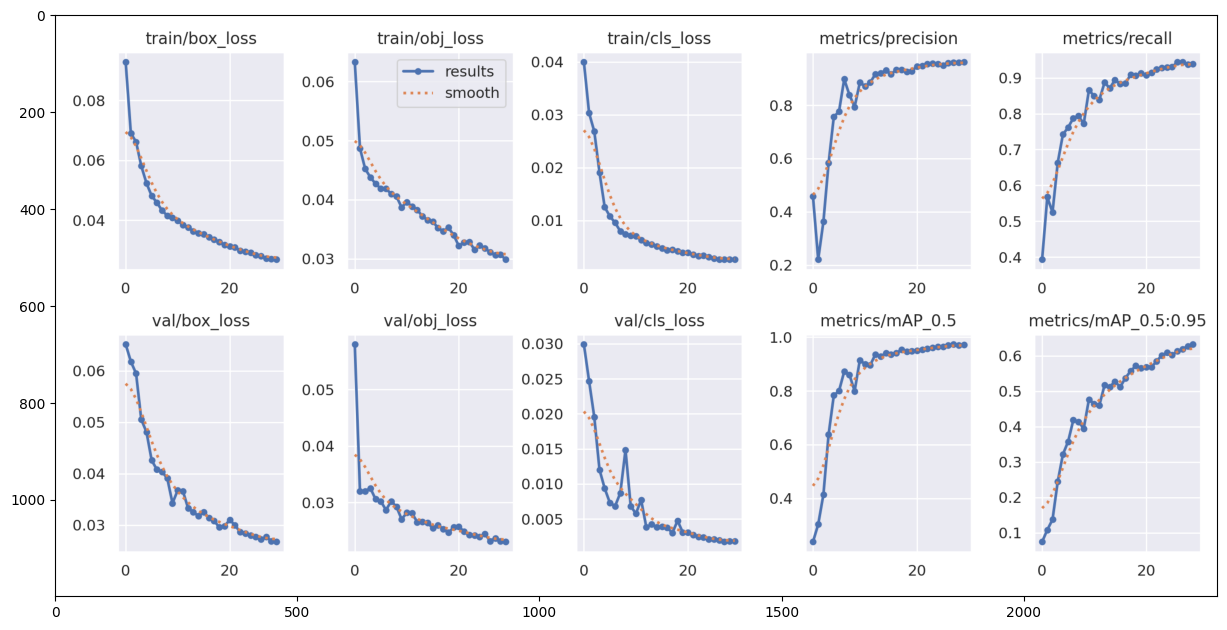

In [ ]:
img = Image.open('/content/yolov5/runs/train/exp/results.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show

In [ ]:
!mkdir '/content/yolov5/images/test/'
move_data(test_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'test', img=True)

In [ ]:
!python detect.py --img 640 --source /content/yolov5/images/test/  --weights /content/yolov5/runs/train/exp/weights/best.pt --conf 0.25

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolov5/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20865057 parameters, 0 gradients, 47.9 GFLOPs
image 1/197 /content/yolov5/images/test/HardHat0338_jpg.rf.dbde065e724a6c3f21c2974b503e884c.jpg: 640x640 4 Helmets, 3 NoJackets, 27.0ms
image 2/197 /content/yolov5/images/test/HardHat0353_jpg.rf.bd0ec1b3e96aa315b6e410cd4d25e24f.jpg: 640x640 5 Helmets, 3 NoJackets, 27.0ms
image 3/197 /content/yolov5/im

In [ ]:
!zip -r /content/file.zip /content/yolov5/runs/detect/exp/

  adding: content/yolov5/runs/detect/exp/ (stored 0%)
  adding: content/yolov5/runs/detect/exp/Hardhat0206_jpg.rf.a7429d11937705d5ade5aee152468a55.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp/HardHat0446_jpg.rf.df6b325dcf1e89c64933e78f77ace5f3.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/Hardhat0207_jpg.rf.a9c37d2f150228ffe7519d6b6cf5384d.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/Hardhat0037_JPG.rf.5e42b6595342f3c8570b78f88b222437.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp/Hardhat277_jpg.rf.2cabc1644b3d32e43e9b32634edb7037.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp/HardHat0444_jpg.rf.2226ac4f447768a489eb0887b2d00a5c.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp/Hardhat0033_JPG.rf.61e4046b3452f0f16200533c5d089e59.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/Hardhat0037_JPG.rf.ef9674290fdd57225c06c59bd22f948f.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/HardHat0368_jpg.rf

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
n = random.randint(0,196)
img = Image.open('/content/yolov5/runs/detect/exp/'+os.listdir('/content/yolov5/runs/detect/exp/')[n])
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show

UnidentifiedImageError: ignored